In [1]:
%%html
<link rel="stylesheet" type="text/css" href="rise.css" />

# Optimization
**Learning goals**
- You will be able to find optimal parameters for any model by minimizing an error function that compares the model to data.
- You will understand the concept of gradient descent.
- You will understand the difference between local and global optimization.

Import and setup numpy and matplotlib.

In [2]:
import numpy as np

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use("bmh")
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12

## General approach to optimization
1. Define a model to explain your data.
2. Adjust the model parameters to minimize the error between the model prediction and the data.

## Example: Curve fitting 

Consider the decay time course of an excitatory postsynaptic current (EPSC).

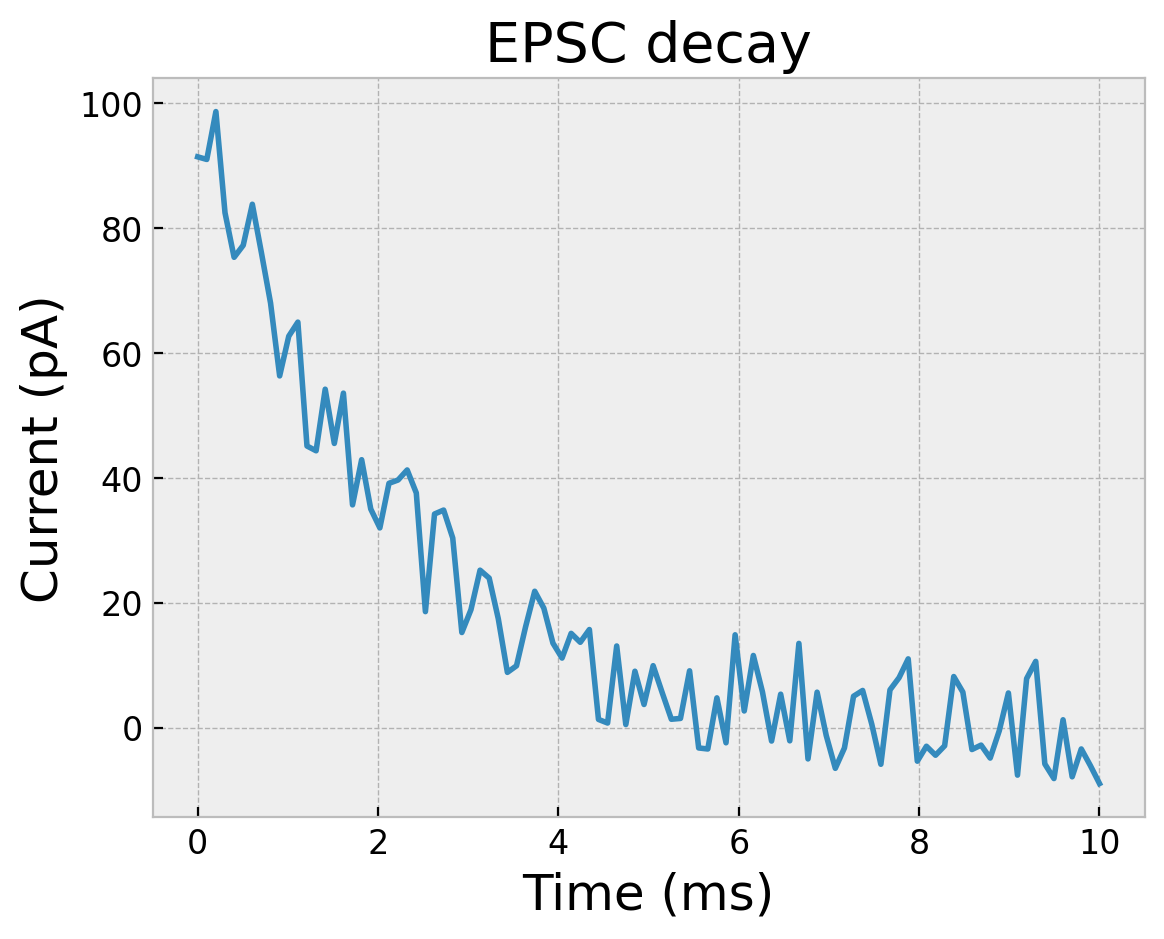

In [3]:
time_ms = np.linspace(0, 10, 100)
epsc_decay_pA = 100 * np.exp(-time_ms / 2) + 20 * (np.random.rand(len(time_ms)) - 0.5)

plt.plot(time_ms, epsc_decay_pA)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('EPSC decay');

Define a function to model the EPSC decay.

In [4]:
def my_decay(time, params):
    amp, tau = params
    return amp * np.exp(-time / tau)

Guess parameters that seem reasonable.

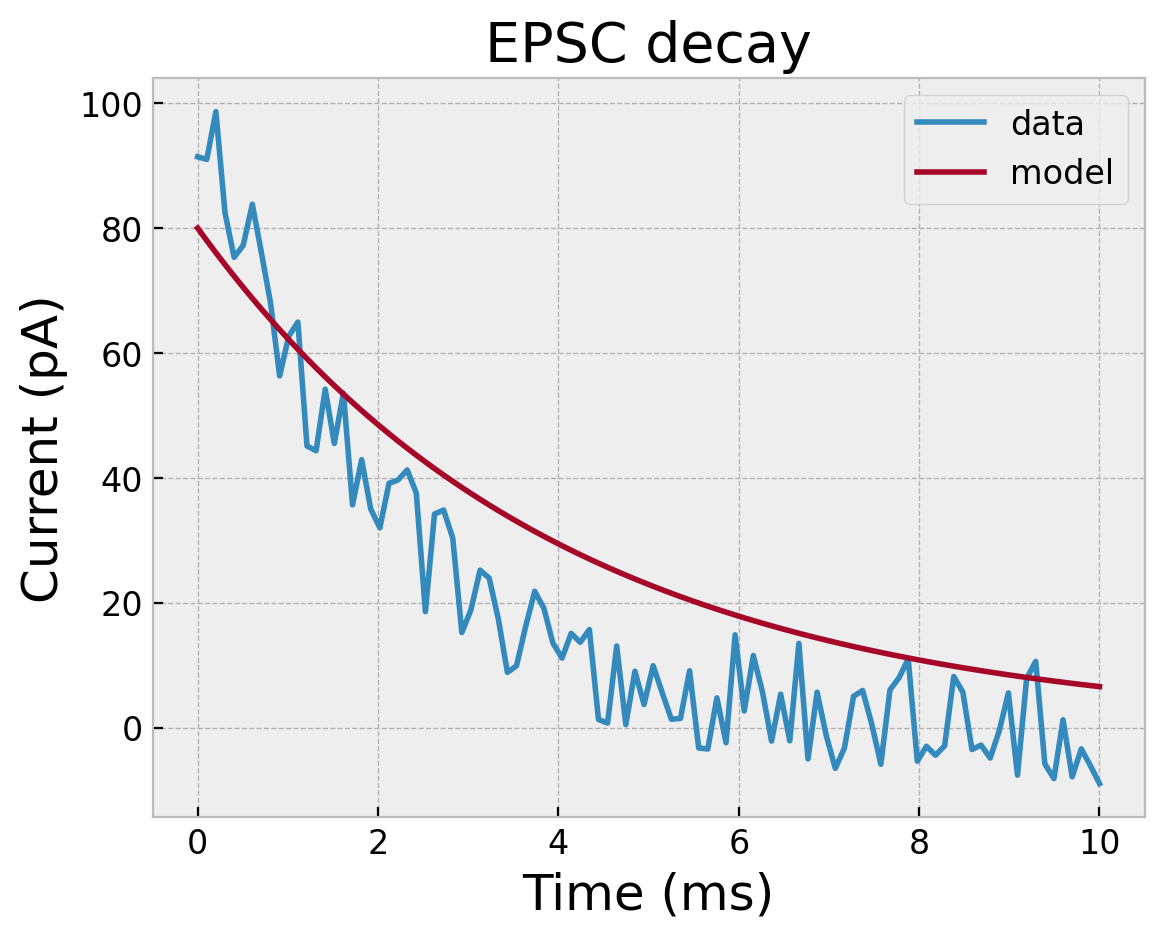

In [5]:
initial_params = [80, 4]

fit = my_decay(time_ms, initial_params)

plt.plot(time_ms, epsc_decay_pA, label='data')
plt.plot(time_ms, fit, label='model')
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('EPSC decay')
plt.legend();

Define an error function that returns the sum of squared errors (SSE) between the model prediction and the EPSC data.

In [6]:
def sse(params):
    data = epsc_decay_pA
    model = my_decay(time_ms, params)
    return np.sum((data - model)**2)

Find the model parameters that minimize the SSE between the model decay and the EPSC data.

In [7]:
import scipy.optimize as opt

In [8]:
result = opt.minimize(sse, initial_params, method='slsqp', bounds=[(50, 150), (0.1, 10)])
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3870.453177099222
       x: [ 1.001e+02  1.984e+00]
     nit: 11
     jac: [ 2.380e-03  7.446e-02]
    nfev: 37
    njev: 11

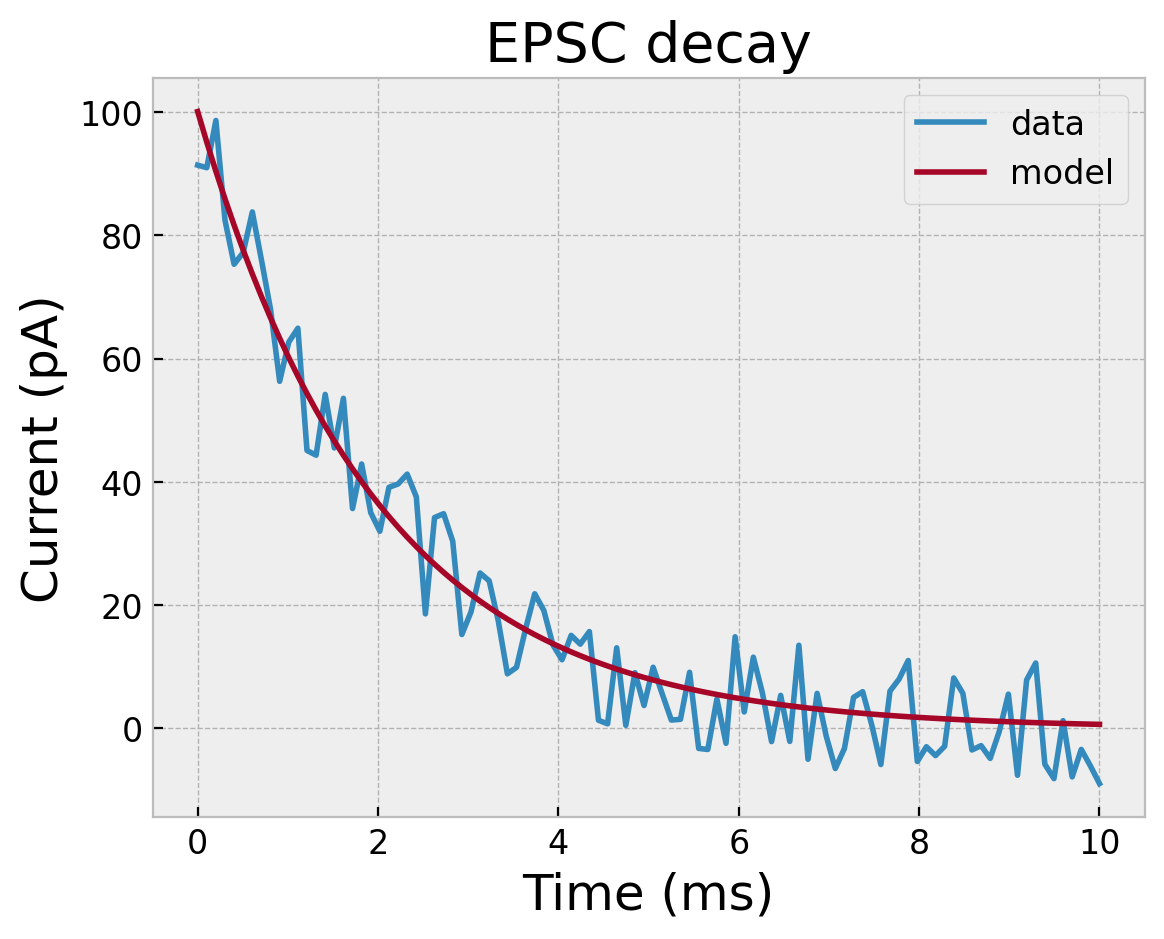

In [9]:
fit = my_decay(time_ms, result.x)

plt.plot(time_ms, epsc_decay_pA, label='data')
plt.plot(time_ms, fit, label='model')
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('EPSC decay')
plt.legend();

Visualize the 2D SSE surface that we were searching for a minimum on in the EPSC decay example above.

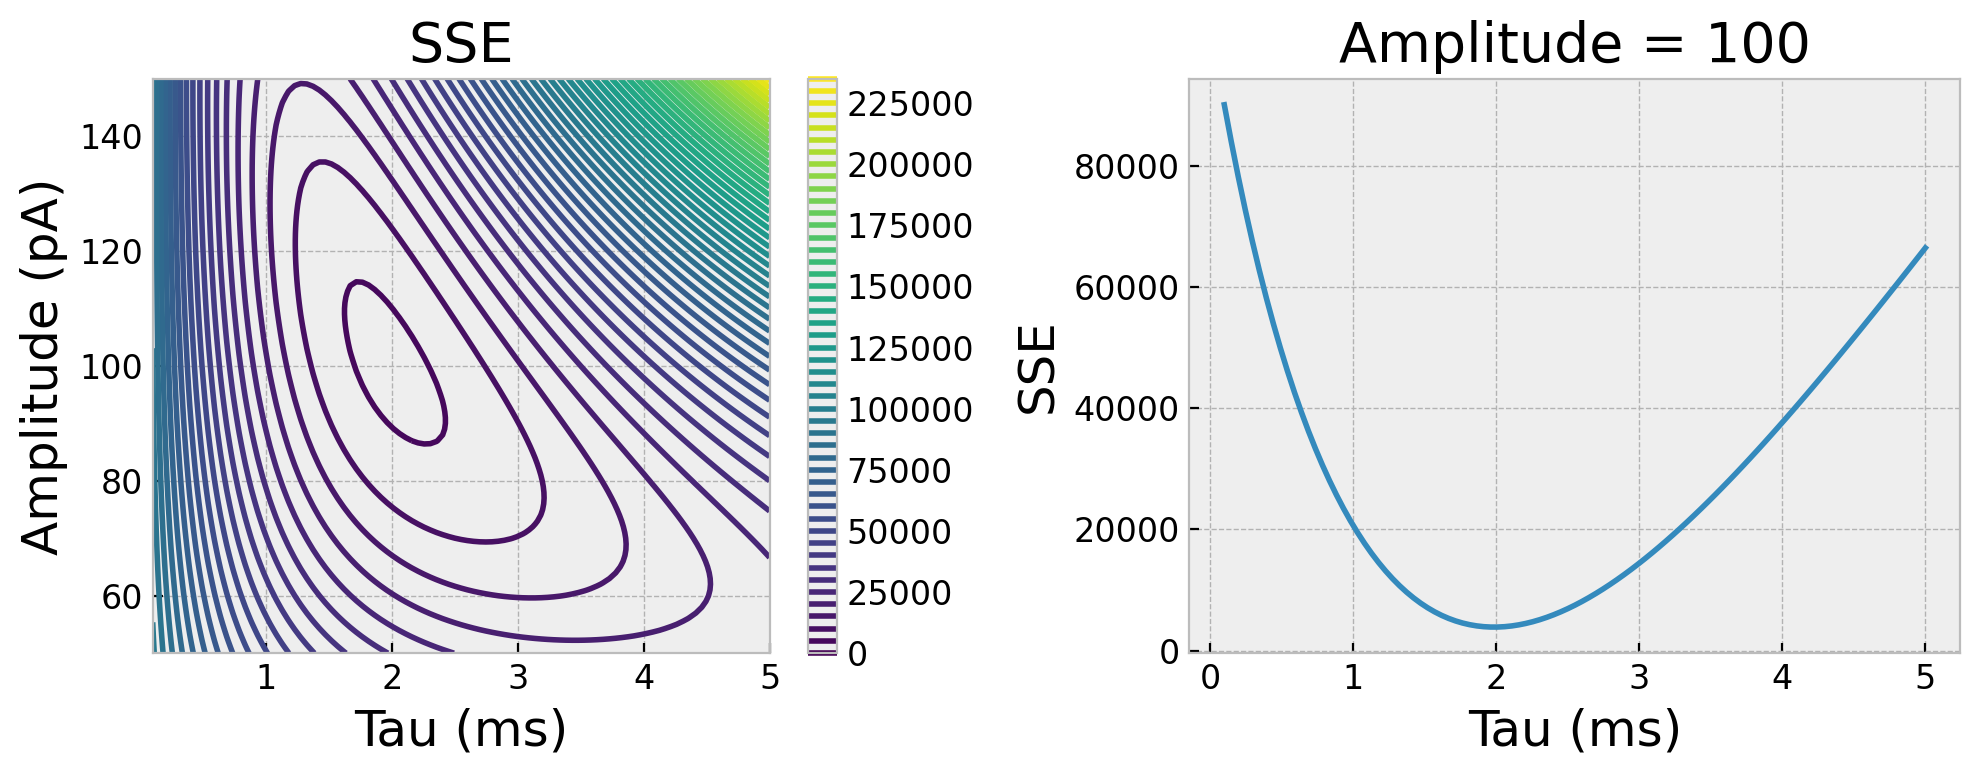

In [10]:
# SSE surface
amps = np.linspace(50, 150, 101)
taus = np.linspace(0.1, 5, 101)

cost = np.zeros((len(amps), len(taus)))

for i, amp in enumerate(amps):
    for j, tau in enumerate(taus):
        cost[i,j] = sse([amp, tau])

plt.figure(figsize=(10,4))
# rows = amps, columns = taus ==> x = taus, y = amps
plt.subplot(1, 2, 1)
plt.contour(taus, amps, cost, 50)
# plt.hlines(amps[50], taus[0], taus[-1])
plt.xlabel('Tau (ms)')
plt.ylabel('Amplitude (pA)')
plt.title('SSE')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.plot(taus, cost[50,:])
plt.xlabel('Tau (ms)')
plt.ylabel('SSE')
plt.title(f'Amplitude = {amps[50]:.0f}')
plt.tight_layout();

It is difficult to visualize, but mathematically simple to find a minimum in three or more dimensions (i.e, three or more parameters).

# Gradient Descent

<img src="images/gradient-descent.gif" width="50%">

# Global vs Local Minima

<img src="images/local-global-minima.png" width="75%">

Consider a simple function with two local minima and one global minima.

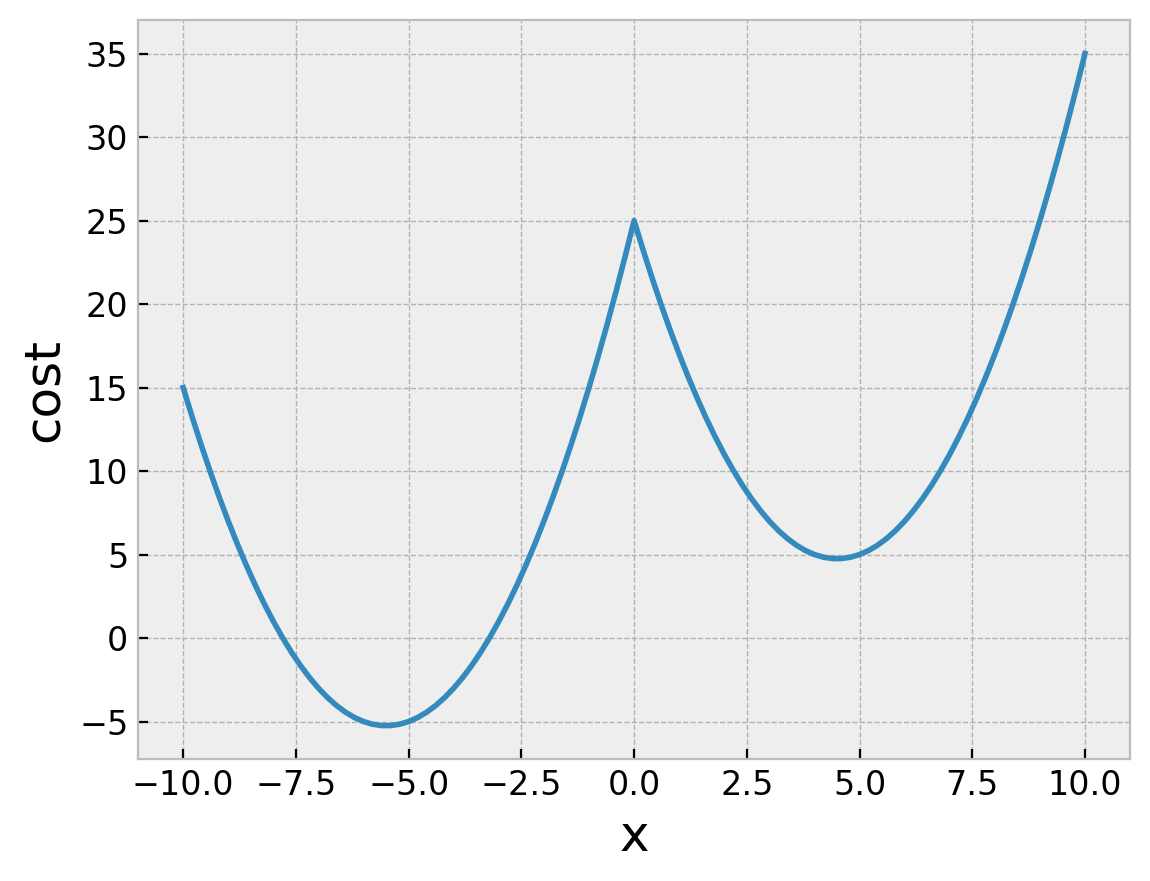

In [11]:
def my_error(x):
    return (abs(x) - 5)**2 + x

x = np.linspace(-10, 10, 101)
plt.plot(x, my_error(x))
plt.xlabel('x')
plt.ylabel('cost');

Find the minima starting at either $x=-10$ or $x=+10$.

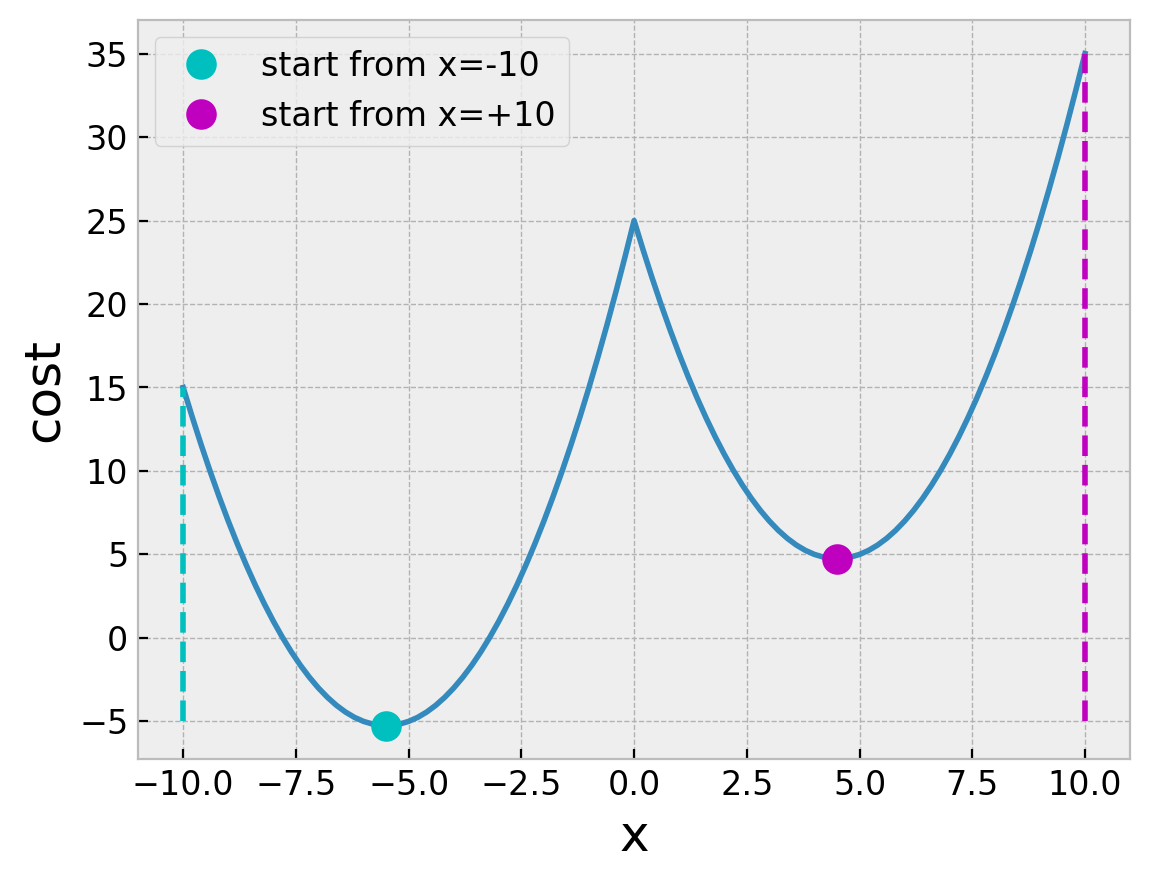

In [12]:
result_from_left = opt.minimize(my_error, [-10])
xmin_from_left = result_from_left.x[0]

result_from_right = opt.minimize(my_error, [+10])
xmin_from_right = result_from_right.x[0]

plt.plot(x, my_error(x))
plt.plot(xmin_from_left, my_error(xmin_from_left), 'co', ms=10, label='start from x=-10')
plt.plot(xmin_from_right, my_error(xmin_from_right), 'mo', ms=10, label='start from x=+10')
plt.vlines(-10, -5, 15, 'c', ls='--')
plt.vlines(+10, -5, 35, 'm', ls='--')
plt.xlabel('x')
plt.ylabel('cost')
plt.legend();

# Global Minima

There are a number of methods that attempt to find the global minima rather than the nearest local minima.

[e.g. basin hopping, brute force, annealing, SHG.](https://docs.scipy.org/doc/scipy/reference/optimize.html)

<img src="images/local-global-minima.png" width="50%">

Find global minimum using dual annealing.

In [13]:
# find value global minimum within the range -10 <= x <= 10.
result = opt.dual_annealing(my_error, bounds=[(-10, 10)])

result

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: -5.25
       x: [-5.500e+00]
     nit: 1000
    nfev: 2009
    njev: 4
    nhev: 0

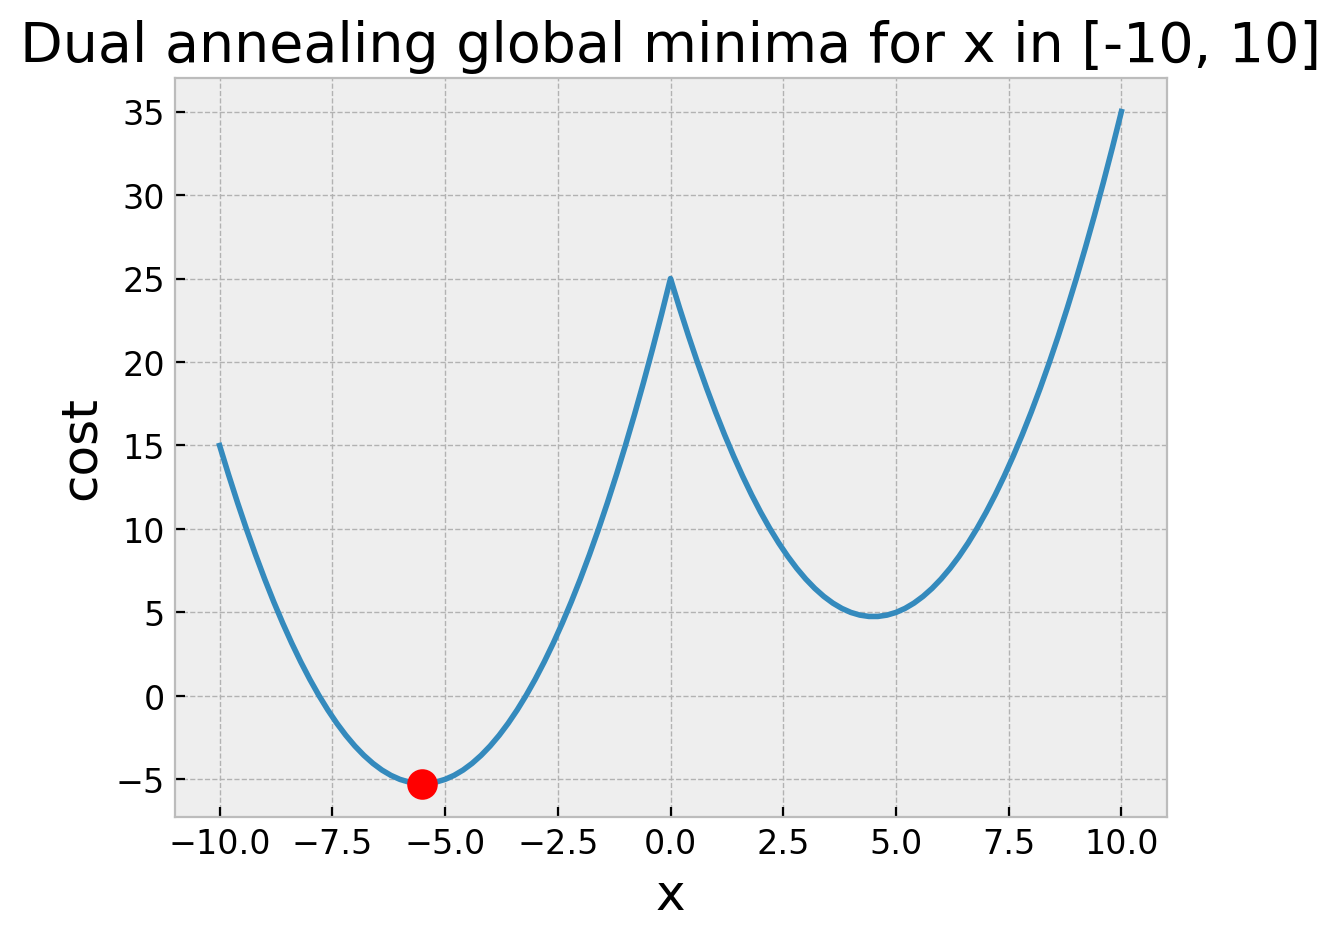

In [14]:
xmin = result.x[0]

plt.plot(x, my_error(x))
plt.plot(xmin, my_error(xmin), 'ro', ms=10)
plt.xlabel('x')
plt.ylabel('cost')
plt.title('Dual annealing global minima for x in [-10, 10]');